<a href="https://colab.research.google.com/github/FJWangYantao/FJWangYantao.github.io/blob/main/4_3_Example_of_buston_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets)=boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [6]:
#对数据进行标准化
mean=train_data.mean(axis=0)
train_data-=mean
test_data-=mean
std=train_data.std(axis=0)
train_data/=std
test_data/=std


训练数据越少，过拟合越严重，较小的模型可以降低过拟合

In [11]:
from tensorflow import keras
def build_model():
  model=keras.Sequential([
      layers.Dense(64,activation="relu"),
      layers.Dense(64,activation="relu"),
      #只有一个单元且没有激活，标量回归的典型设置，添加激活函数将会限制输出范围，得到不准确的结果
      layers.Dense(1)
  ])

  model.compile(
      optimizer="rmsprop",
      loss="mse",#均方误差
      metrics=["mae"]
  )
  return model

In [17]:
import numpy as np
from tensorflow.keras import layers
#K折交叉验证
k=4
num_val_samples=len(train_data)//k
num_epochs=500
all_mae_histories=[]
for i in range(k):
  #i表示折数
  print(f"Processing fold #{i}")
  #循环取出每折作为验证数据
  val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
  #剩下的数据作为训练数据，axis=0表示按照行连接
  partial_train_data=np.concatenate(
      [train_data[:i*num_val_samples],
       train_data[(i+1)*num_val_samples:]],
      axis=0
  )
  partial_target_data=np.concatenate(
      [train_targets[:i*num_val_samples],
       train_targets[(i+1)*num_val_samples:]],
       axis=0
  )
  #编译并训练模型
  model=build_model()
  history=model.fit(partial_train_data,
      partial_target_data,
      validation_data=(val_data,val_targets),
        epochs=num_epochs,
        batch_size=16,
        verbose=0)
  #mae
  mae_history=history.history["val_mae"]
  all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
#保存每个epoch的平均绝对误差
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

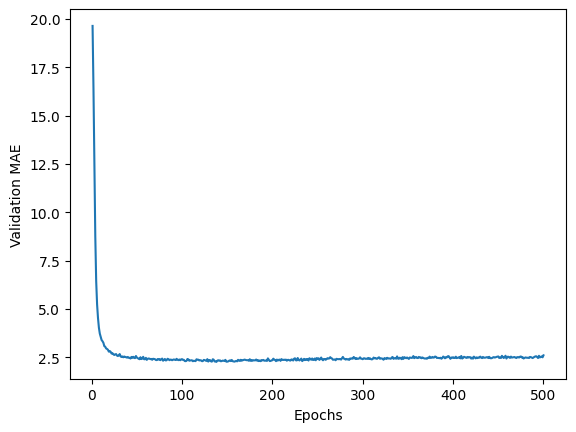

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(average_mae_history)+1),
         average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

由于前几轮的MAE远大于后几轮的MAE，所以看起来比较不明显，所以剔除前十个数据点

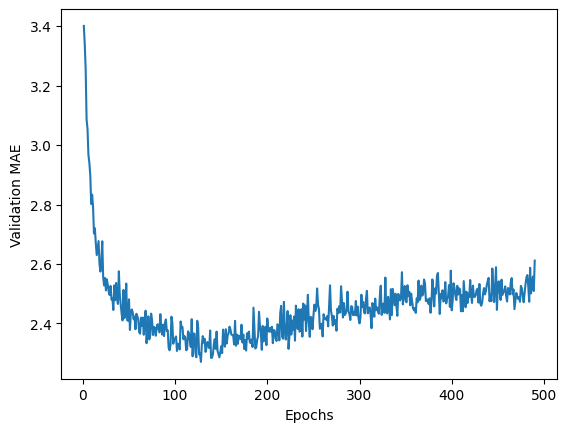

In [22]:
#通过绘图找出MAE开始上升的点，以此作为过拟合的标志
truncated_mae_history=average_mae_history[10:]
plt.plot(range(1,len(truncated_mae_history)+1),
    truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [24]:
#大约在130轮之后开始过拟合，MAE开始上升
model=build_model()
model.fit(train_data,train_targets,
          epochs=130,
          batch_size=16,
          verbose=0)
test_mse_score,test_mae_score=model.evaluate(test_data,test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 16.3883 - mae: 2.6161


In [26]:
#用来预测数据
predictions=model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 4ms/step


array([9.09034], dtype=float32)